# Chtěli jste dokumentaci? BUDE DOKUMENTACE

následně vám v rychlém sledu popíšu vše co se zde bude dít rozdělíme to na fáze jako je strukturovaný projekt

## konfigurace (phase 0)
toto pole slouží pro jednodušší úpravu modelu pro případný fine tunning a výběr modelu. stejně zde i vybrat soubor určený pro import dat na trénování klasifikovacího modelu
## phase 1
zde se pouze načte soubor,zkombinuje nadpis a text a také přejmenujou sloupce pro další práci. zároveň také dojde k zobrazení distribuce pozorování podle délky a podle počtu v kategoriích asshole a not the asshole

## phase 2

pouze stratifikovaný split podle labelu pro stejný poměr  v train,test i valid samplu.

## phase 3
tokenizace a ukazuje distribuci postů podle počtu tokenů 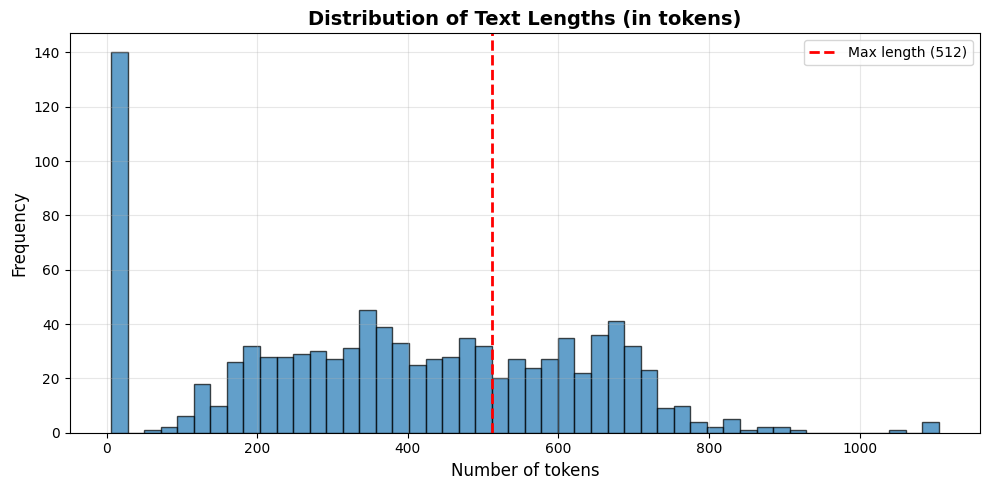
## phase 4
zde se prvně checkne jestli lze použít gpu pro trénování modelu a pak se zde definuje model který klasifikuje posty. Model je mělká neuronová síť, která vezme CLS token vytvořený při tokenizaci postů a prožene ho mělkou neurono vou sítí s ReLu funkcemi

rozměry neuronové sítě:
 - input: 768
 - processing layer(only one): 768
 - classification layer: 2
## phase 5
 zde se jen vloží definované hyperparametry ve fázi 1
## phase 6
trénování modelu a ukázání metrik po epochách
## phase 7
hodnocení finálního modelu (confusion matice a confidence distribuce podle správné/špatné klasifikace)
## phase 8
uložení modelu
## phase 9
přetvoření na funkci kterou lze použít pro backend asi?


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from torch import nn

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================


# Model selection - Choose one:
#MODEL_NAME = "albert-base-v2"  # Much smaller than DistilBERT
#MODEL_NAME = "distilbert-base-uncased"  # RECOMMENDED: Fast & good performance
MODEL_NAME = "roberta-base"           # Best performance
# MODEL_NAME = "bert-base-uncased"      # Classic choice

# File paths
DATA_FILE = 'processed_sample_250000-1.csv'  # ← YOUR CSV FILE NAME HERE
OUTPUT_DIR = f'./final_model_{MODEL_NAME.replace("/", "_")}'

# CSV column names (UPDATE THESE to match your CSV)
CSV_COLUMNS = {
    'text': 'selftext',           # Column with post content
    'label': 'link_flair_text'    # Column with verdict/label
}

# Note: No separate 'title' column in your CSV
# The 'selftext' column already contains the full text

# Label mapping (based on your data)
LABEL_MAP = {
    'not the asshole': 0,  # NTA (lowercase in your data)
    'asshole': 1           # YTA (lowercase in your data)
}

ID2LABEL = {0: "NTA", 1: "YTA"}
LABEL2ID = {"NTA": 0, "YTA": 1}

# Training hyperparameters
TRAIN_CONFIG = {
    'test_size': 0.15,           # 15% for test
    'val_size': 0.10,            # 10% for validation
    'max_length': 512,           # BERT max sequence length
    'batch_size_train': 32,      # Training batch size
    'batch_size_eval': 64,       # Evaluation batch size
    'learning_rate': 1e-5,       # Learning rate
    'num_epochs': 4,             # Number of training epochs
    'warmup_steps': 500,         # Warmup steps
    'weight_decay': 0.05,        # Weight decay
    'random_state': 42
}

print(f"\nModel: {MODEL_NAME}")
print(f"Data file: {DATA_FILE}")
print(f"Configuration: {TRAIN_CONFIG}")


Model: roberta-base
Data file: processed_sample_250000-1.csv
Configuration: {'test_size': 0.15, 'val_size': 0.1, 'max_length': 512, 'batch_size_train': 32, 'batch_size_eval': 64, 'learning_rate': 1e-05, 'num_epochs': 4, 'warmup_steps': 500, 'weight_decay': 0.05, 'random_state': 42}


In [3]:
# ============================================================================
# PHASE 1: DATA LOADING AND PREPARATION
# ============================================================================

print("\n" + "="*80)
print("PHASE 1: DATA LOADING AND PREPARATION")
print("="*80)

# Load CSV file
print(f"\nLoading data from {DATA_FILE}...")
df = pd.read_csv(
    DATA_FILE,
    engine="python",
    on_bad_lines="skip",
    sep=";",
    quotechar='"'
)



print(f"✅ Loaded {len(df):,} rows")
print(f"\nDataFrame info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.columns.tolist()}")

# Display sample
print(f"\n📄 Sample data:")
print(df.head(2))

# Check column names
text_col = CSV_COLUMNS['text']
label_col = CSV_COLUMNS['label']

if text_col not in df.columns:
    print(f"❌ Error: Column '{text_col}' not found!")
    print(f"Available columns: {df.columns.tolist()}")
    raise ValueError(f"Column '{text_col}' not found in CSV")

if label_col not in df.columns:
    print(f"❌ Error: Column '{label_col}' not found!")
    print(f"Available columns: {df.columns.tolist()}")
    raise ValueError(f"Column '{label_col}' not found in CSV")

print(f"\n✅ Using columns:")
print(f"  Text: '{text_col}'")
print(f"  Label: '{label_col}'")

# Rename columns for consistency
df = df.rename(columns={
    text_col: 'full_text',
    label_col: 'label_text'
})

# Clean text
print(f"\n🧹 Cleaning data...")
initial_count = len(df)

# Remove missing values
df = df[df['full_text'].notna()]
df = df[df['full_text'].str.strip() != '']
df = df[df['label_text'].notna()]

print(f"  Removed {initial_count - len(df)} rows with missing data")
print(f"  Remaining: {len(df):,} posts")

# Basic text cleaning
def clean_text(text):
    """Basic text cleaning"""
    text = str(text)
    text = ' '.join(text.split())  # Remove excessive whitespace
    if len(text) > 10000:
        text = text[:10000]  # Truncate very long texts
    return text

df['full_text'] = df['full_text'].apply(clean_text)

# ============================================
# FILTER TO ONLY 2 MAIN CATEGORIES
# ============================================
print(f"\n🎯 Filtering to keep only 'Not the A-hole' and 'Asshole'...")

# Before filtering
before = len(df)
print(f"Before filtering: {before:,} posts")

# Keep only these 2 labels (case-sensitive, exact match)
valid_labels = ['Not the A-hole', 'Asshole']
df = df[df['label_text'].isin(valid_labels)]

# After filtering
after = len(df)
dropped = before - after
print(f"After filtering: {after:,} posts")
print(f"Dropped: {dropped:,} posts")

# Show final distribution
print(f"\n📊 Final label distribution:")
for label, count in df['label_text'].value_counts().items():
    pct = count / len(df) * 100
    print(f"  '{label}': {count:,} ({pct:.1f}%)")

# ============================================
# ENCODE LABELS (NO MORE FILTERING!)
# ============================================
print(f"\n🔢 Encoding labels...")

# Map labels to 0 and 1
LABEL_MAP = {
    'Not the A-hole': 0,  # NTA
    'Asshole': 1          # YTA
}

df['label'] = df['label_text'].map(LABEL_MAP)

# Check for unmapped labels (should be 0 after filtering above)
unmapped = df[df['label'].isna()]
if len(unmapped) > 0:
    print(f"  ⚠️  WARNING: {len(unmapped)} samples have unmapped labels")
    print(f"  Unique unmapped values: {unmapped['label_text'].unique()}")
    df = df[df['label'].notna()]

df['label'] = df['label'].astype(int)

# Display final label distribution
print(f"\n📊 Encoded label distribution:")
label_counts = df['label'].value_counts().sort_index()
for label_id, count in label_counts.items():
    label_name = ID2LABEL[label_id]
    original_text = [k for k, v in LABEL_MAP.items() if v == label_id][0]
    percentage = count / len(df) * 100
    print(f"  {label_name} ('{original_text}'): {count:,} ({percentage:.1f}%)")

# Check class imbalance
if len(label_counts) >= 2:
    class_ratio = label_counts.max() / label_counts.min()
    print(f"\n⚖️  Class imbalance ratio: {class_ratio:.2f}:1")
    if class_ratio > 2:
        print("  ⚠️  Significant class imbalance detected. Will use weighted loss.")
    elif class_ratio > 1.5:
        print("  ℹ️  Moderate class imbalance. Weighted loss recommended.")
    else:
        print("  ✅ Classes are relatively balanced.")

# Display text statistics
print(f"\n📏 Text statistics:")
text_lengths = df['full_text'].str.len()
print(f"  Mean length: {text_lengths.mean():.1f} characters")
print(f"  Median length: {text_lengths.median():.1f} characters")
print(f"  Min length: {text_lengths.min()} characters")
print(f"  Max length: {text_lengths.max():,} characters")
print(f"  Std dev: {text_lengths.std():.1f} characters")

# Show example posts
print(f"\n📝 Example posts:")
for label_name in ['Not the A-hole', 'Asshole']:
    if label_name in df['label_text'].values:
        sample = df[df['label_text'] == label_name].iloc[0]
        print(f"\n  '{label_name}' example:")
        print(f"    {sample['full_text'][:200]}...")

print(f"\n✅ Data preparation complete!")
print(f"   Final dataset: {len(df):,} posts ready for training")



PHASE 1: DATA LOADING AND PREPARATION

Loading data from processed_sample_250000-1.csv...
✅ Loaded 199,145 rows

DataFrame info:
  Shape: (199145, 3)
  Columns: ['selftext', 'link_flair_text', 'target']

📄 Sample data:
                                            selftext  link_flair_text  target
0  My four roommates and I (all in college) went ...  not the asshole       0
1  I'd like to start out by saying I know for a f...  not the asshole       0

✅ Using columns:
  Text: 'selftext'
  Label: 'link_flair_text'

🧹 Cleaning data...
  Removed 90 rows with missing data
  Remaining: 199,055 posts

🎯 Filtering to keep only 'Not the A-hole' and 'Asshole'...
Before filtering: 199,055 posts
After filtering: 196,015 posts
Dropped: 3,040 posts

📊 Final label distribution:
  'Not the A-hole': 155,408 (79.3%)
  'Asshole': 40,607 (20.7%)

🔢 Encoding labels...

📊 Encoded label distribution:
  NTA ('Not the A-hole'): 155,408 (79.3%)
  YTA ('Asshole'): 40,607 (20.7%)

⚖️  Class imbalance ratio: 3.83:

In [4]:
# ============================================================================
# PHASE 2: TRAIN/VAL/TEST SPLIT
# ============================================================================

print("\n" + "="*80)
print("PHASE 2: TRAIN/VAL/TEST SPLIT")
print("="*80)

# Select only needed columns
df_clean = df[['full_text', 'label']].copy()

# First split: separate test set
train_val_df, test_df = train_test_split(
    df_clean,
    test_size=TRAIN_CONFIG['test_size'],
    random_state=TRAIN_CONFIG['random_state'],
    stratify=df_clean['label']
)

# Second split: separate validation set
val_ratio = TRAIN_CONFIG['val_size'] / (1 - TRAIN_CONFIG['test_size'])
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_ratio,
    random_state=TRAIN_CONFIG['random_state'],
    stratify=train_val_df['label']
)

print(f"\nDataset split:")
print(f"  Train: {len(train_df):,} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df):,} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df):,} samples ({len(test_df)/len(df)*100:.1f}%)")

# Verify class distribution in splits
print("\nClass distribution in each split:")
for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    counts = split_df['label'].value_counts().sort_index()
    print(f"  {split_name}:")
    for label_id, count in counts.items():
        print(f"    {ID2LABEL[label_id]}: {count} ({count/len(split_df)*100:.1f}%)")



PHASE 2: TRAIN/VAL/TEST SPLIT

Dataset split:
  Train: 147,010 samples (75.0%)
  Val:   19,602 samples (10.0%)
  Test:  29,403 samples (15.0%)

Class distribution in each split:
  Train:
    NTA: 116555 (79.3%)
    YTA: 30455 (20.7%)
  Val:
    NTA: 15541 (79.3%)
    YTA: 4061 (20.7%)
  Test:
    NTA: 23312 (79.3%)
    YTA: 6091 (20.7%)



PHASE 3: TOKENIZATION

Loading tokenizer: roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (738 > 512). Running this sequence through the model will result in indexing errors


Tokenizer loaded successfully!
  Vocab size: 50,265
  Model max length: 512

Analyzing text lengths...

Token length statistics (sample of 1000):
  Mean: 451.3
  Median: 433.0
  Max: 1724
  95th percentile: 745.0
  99th percentile: 1005.2

Texts that will be truncated: 38.6%

Saved: token_length_distribution.png

Creating HuggingFace datasets...

Tokenizing datasets (this may take a few minutes)...


Map:   0%|          | 0/147010 [00:00<?, ? examples/s]

Map:   0%|          | 0/19602 [00:00<?, ? examples/s]

Map:   0%|          | 0/29403 [00:00<?, ? examples/s]


Tokenization complete!
  Train dataset: 147010 samples
  Val dataset: 19602 samples
  Test dataset: 29403 samples


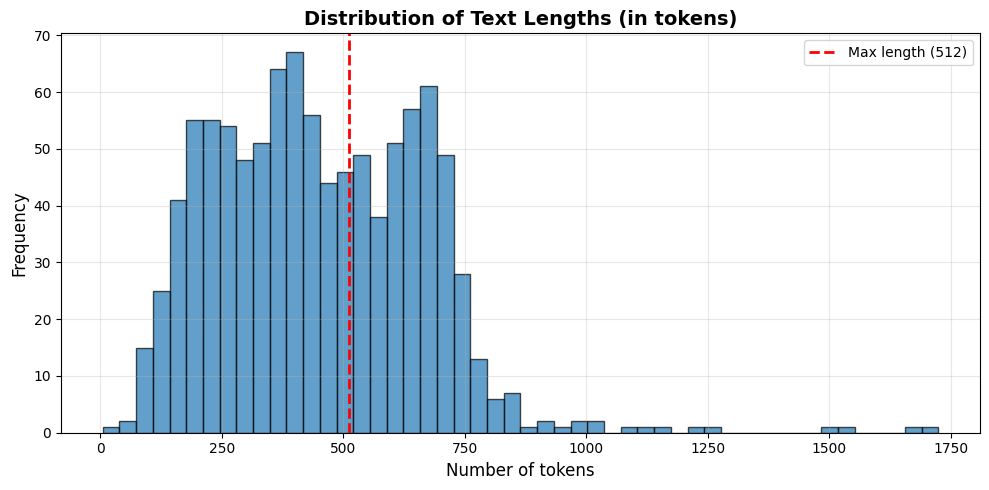

In [5]:
# ============================================================================
# PHASE 3: TOKENIZATION
# ============================================================================

print("\n" + "="*80)
print("PHASE 3: TOKENIZATION")
print("="*80)

# Load tokenizer
print(f"\nLoading tokenizer: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer loaded successfully!")
print(f"  Vocab size: {tokenizer.vocab_size:,}")
print(f"  Model max length: {tokenizer.model_max_length}")

# Analyze text lengths
print("\nAnalyzing text lengths...")
train_lengths = []
for text in train_df['full_text'].values[:1000]:  # Sample for speed
    tokens = tokenizer.encode(text, truncation=False, add_special_tokens=True)
    train_lengths.append(len(tokens))

train_lengths = np.array(train_lengths)

print(f"\nToken length statistics (sample of 1000):")
print(f"  Mean: {train_lengths.mean():.1f}")
print(f"  Median: {np.median(train_lengths):.1f}")
print(f"  Max: {train_lengths.max()}")
print(f"  95th percentile: {np.percentile(train_lengths, 95):.1f}")
print(f"  99th percentile: {np.percentile(train_lengths, 99):.1f}")

truncated_pct = (train_lengths > TRAIN_CONFIG['max_length']).sum() / len(train_lengths) * 100
print(f"\nTexts that will be truncated: {truncated_pct:.1f}%")

# Plot length distribution
plt.figure(figsize=(10, 5))
plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(TRAIN_CONFIG['max_length'], color='red', linestyle='--',
            label=f'Max length ({TRAIN_CONFIG["max_length"]})', linewidth=2)
plt.xlabel('Number of tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Text Lengths (in tokens)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('token_length_distribution.png', dpi=300, bbox_inches='tight')
print("\nSaved: token_length_distribution.png")

# Create HuggingFace datasets
print("\nCreating HuggingFace datasets...")
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# Tokenization function
def tokenize_function(examples):
    """Tokenize text data"""
    return tokenizer(
        examples['full_text'],
        padding='max_length',
        truncation=True,
        max_length=TRAIN_CONFIG['max_length'],
        return_tensors=None
    )

# Tokenize datasets
print("\nTokenizing datasets (this may take a few minutes)...")
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['full_text']
)

val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['full_text']
)

test_dataset = test_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['full_text']
)

# Rename and format
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("\nTokenization complete!")
print(f"  Train dataset: {len(train_dataset)} samples")
print(f"  Val dataset: {len(val_dataset)} samples")
print(f"  Test dataset: {len(test_dataset)} samples")

In [6]:
# ============================================================================
# PHASE 4: MODEL SETUP
# ============================================================================

print("\n" + "="*80)
print("PHASE 4: MODEL SETUP")
print("="*80)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Load model
print(f"\nLoading model: {MODEL_NAME}...")
num_labels = len(LABEL_MAP)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=ID2LABEL,
    label2id=LABEL2ID,
    problem_type="single_label_classification"
)

print(f"Model loaded successfully!")
print(f"  Total parameters: {model.num_parameters():,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Calculate class weights - AGGRESSIVE VERSION
class_counts = train_df['label'].value_counts().sort_index()

print(f"\nClass distribution:")
for i, count in class_counts.items():
    print(f"  {ID2LABEL[i]}: {count:,} ({count/len(train_df)*100:.1f}%)")

# OPTION 1: Simple aggressive weights (RECOMMENDED)
class_weights = torch.tensor([1.0, 8.0], dtype=torch.float)

# OPTION 2: Calculated from data (less aggressive)
# class_weights = torch.tensor([
#     1.0,
#     class_counts[0] / class_counts[1]  # 13220 / 3556 = 3.71
# ], dtype=torch.float)

# OPTION 3: Very aggressive (if YTA recall still low)
# class_weights = torch.tensor([1.0, 7.0], dtype=torch.float)

print(f"\nClass weights (for weighted loss):")
for i, weight in enumerate(class_weights):
    print(f"  {ID2LABEL[i]}: {weight:.3f}")

print(f"Weight ratio (YTA:NTA): {class_weights[1]/class_weights[0]:.2f}:1")

print("\n" + "="*80)
print("DEFINING WEIGHTED TRAINER CLASS")
print("="*80)

class WeightedTrainer(Trainer):
    """
    Custom Trainer that applies class weights to handle imbalanced data.

    This modifies the loss calculation to make YTA errors 6× more impactful
    than NTA errors, forcing the model to learn the minority class better.
    """

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Override the default loss computation to apply class weights.

        Args:
            model: The RoBERTa model
            inputs: Batch of tokenized inputs with labels
            return_outputs: Whether to return model outputs (for evaluation)

        Returns:
            loss: Weighted cross-entropy loss
            outputs (optional): Model outputs if return_outputs=True
        """
        # Extract labels from inputs
        labels = inputs.pop("labels")

        # Forward pass through model
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply weighted cross-entropy loss
        # This applies our [1.0, 6.0] weights to make YTA errors 6× more costly
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

print("✅ WeightedTrainer class defined successfully!")
print("   This trainer will apply 6× weight to YTA errors during training.")


PHASE 4: MODEL SETUP

Using device: cuda
  GPU: Tesla T4
  Memory: 15.83 GB

Loading model: roberta-base...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
  Total parameters: 124,647,170
  Trainable parameters: 124,647,170

Class distribution:
  NTA: 116,555 (79.3%)
  YTA: 30,455 (20.7%)

Class weights (for weighted loss):
  NTA: 1.000
  YTA: 8.000
Weight ratio (YTA:NTA): 8.00:1

DEFINING WEIGHTED TRAINER CLASS
✅ WeightedTrainer class defined successfully!
   This trainer will apply 6× weight to YTA errors during training.


In [7]:
# ============================================================================
# PHASE 5: TRAINING CONFIGURATION
# ============================================================================

print("\n" + "="*80)
print("PHASE 5: TRAINING CONFIGURATION")
print("="*80)

# Define metrics
def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
    recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)

    # Per-class metrics
    f1_per_class = f1_score(labels, predictions, average=None, zero_division=0)
    precision_per_class = precision_score(labels, predictions, average=None, zero_division=0)
    recall_per_class = recall_score(labels, predictions, average=None, zero_division=0)

    metrics = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
    }

    # Add per-class metrics
    for i in range(len(f1_per_class)):
        metrics[f'f1_{ID2LABEL[i]}'] = f1_per_class[i]
        metrics[f'precision_{ID2LABEL[i]}'] = precision_per_class[i]
        metrics[f'recall_{ID2LABEL[i]}'] = recall_per_class[i]

    return metrics

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=TRAIN_CONFIG['learning_rate'],
    per_device_train_batch_size=TRAIN_CONFIG['batch_size_train'],
    per_device_eval_batch_size=TRAIN_CONFIG['batch_size_eval'],
    num_train_epochs=TRAIN_CONFIG['num_epochs'],
    weight_decay=TRAIN_CONFIG['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    greater_is_better=True,
    logging_dir='./logs',
    logging_steps=50,
    logging_first_step=True,
    warmup_steps=TRAIN_CONFIG['warmup_steps'],
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    seed=TRAIN_CONFIG['random_state'],
    report_to="none",
)

print("\nTraining configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Train batch size: {training_args.per_device_train_batch_size}")
print(f"  Eval batch size: {training_args.per_device_eval_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Weight decay: {training_args.weight_decay}")
print(f"  FP16 training: {training_args.fp16}")

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\nTrainer initialized!")


PHASE 5: TRAINING CONFIGURATION

Training configuration:
  Epochs: 4
  Train batch size: 32
  Eval batch size: 64
  Learning rate: 1e-05
  Warmup steps: 500
  Weight decay: 0.05
  FP16 training: True

Trainer initialized!


/tmp/ipython-input-1017073387.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [8]:
# ============================================================================
# PHASE 6: TRAINING
# ============================================================================

print("\n" + "="*80)
print("PHASE 6: TRAINING")
print("="*80)

# Estimate training time
steps_per_epoch = len(train_dataset) // (TRAIN_CONFIG['batch_size_train'] * torch.cuda.device_count() if torch.cuda.is_available() else TRAIN_CONFIG['batch_size_train'])
total_steps = steps_per_epoch * TRAIN_CONFIG['num_epochs']
print(f"\nEstimated steps per epoch: {steps_per_epoch}")
print(f"Total training steps: {total_steps}")

print("\n🚀 Starting training...")
print("This may take a while. Grab a coffee! ☕")

# Train
train_result = trainer.train()

# Training summary
print("\n" + "="*80)
print("✅ TRAINING COMPLETE!")
print("="*80)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds ({train_result.metrics['train_runtime']/60:.1f} minutes)")
print(f"Samples per second: {train_result.metrics['train_samples_per_second']:.2f}")


PHASE 6: TRAINING

Estimated steps per epoch: 4594
Total training steps: 18376

🚀 Starting training...
This may take a while. Grab a coffee! ☕


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,F1 Nta,Precision Nta,Recall Nta,F1 Yta,Precision Yta,Recall Yta
1,0.551400,0.536946,0.653862,0.611144,0.686626,0.632032,0.699761,0.740028,0.914662,0.621389,0.482259,0.349403,0.778133
2,0.516400,0.537831,0.673911,0.626993,0.704469,0.639838,0.709586,0.759283,0.915373,0.648671,0.494704,0.364303,0.770500
3,0.447200,0.545192,0.647995,0.608949,0.681317,0.634720,0.704610,0.732517,0.921307,0.607940,0.485382,0.348133,0.801280
4,0.409900,0.645707,0.718855,0.656731,0.742255,0.651885,0.714920,0.802763,0.904435,0.721640,0.510699,0.399334,0.708200



✅ TRAINING COMPLETE!
Training loss: 0.4826
Training time: 14737.23 seconds (245.6 minutes)
Samples per second: 39.90


In [13]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/aitah')

ValueError: Mountpoint must be in a directory that exists


PHASE 7: EVALUATION

Validation Set Evaluation:



Validation Metrics:
  epoch: 4.0000
  eval_accuracy: 0.7189
  eval_f1_NTA: 0.8028
  eval_f1_YTA: 0.5107
  eval_f1_macro: 0.6567
  eval_f1_weighted: 0.7423
  eval_loss: 0.6457
  eval_precision_NTA: 0.9044
  eval_precision_YTA: 0.3993
  eval_precision_macro: 0.6519
  eval_recall_NTA: 0.7216
  eval_recall_YTA: 0.7082
  eval_recall_macro: 0.7149
  eval_samples_per_second: 138.5550
  eval_steps_per_second: 2.1700

TEST SET EVALUATION

Classification Report:
              precision    recall  f1-score   support

         NTA     0.9017    0.7281    0.8056     23312
         YTA     0.4008    0.6961    0.5087      6091

    accuracy                         0.7215     29403
   macro avg     0.6512    0.7121    0.6572     29403
weighted avg     0.7979    0.7215    0.7441     29403


📊 Overall Test Set Metrics:
  Accuracy:     0.7215 (72.15%)
  F1 (macro):   0.6572
  F1 (weighted): 0.7441

💾 Saved: confusion_matrix.png

Confusion Matrix Breakdown:
  True NTA → Predicted NTA: 16973 ( 72.8%)
  Tr

/tmp/ipython-input-2427001352.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([correct_confidences, incorrect_confidences],


💾 Saved: prediction_confidence.png

❌ Misclassified Examples: 8190 (27.9%)

Showing first 3 misclassifications:

  Example 1:
    True label:  NTA
    Predicted:   YTA
    Confidence:  74.32%
    Text (first 150 chars): Hi reddit, I am wondering if i am an assholein this situation. I buy a lot of somewhat expensive shoes to resell and make profit off of. A couple mont...
    Score breakdown: NTA=0.257 YTA=0.743 

  Example 2:
    True label:  NTA
    Predicted:   YTA
    Confidence:  89.26%
    Text (first 150 chars): I could really do with some help understanding if I did something wrong. Let me explain. Me and my friend are really good online friends. We speak eve...
    Score breakdown: NTA=0.107 YTA=0.893 

  Example 3:
    True label:  NTA
    Predicted:   YTA
    Confidence:  59.90%
    Text (first 150 chars): I (27F) have brother (23) -Marc- who basically does nothing productive with his life. Let's not get into much detail, but he had mental issues growing...
    Score breakdow

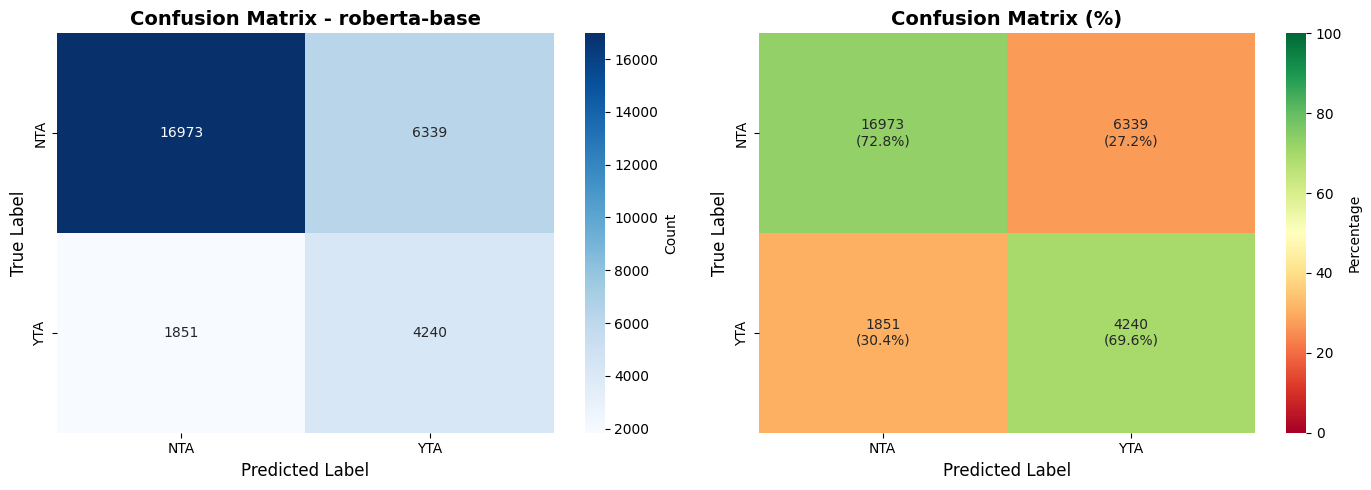

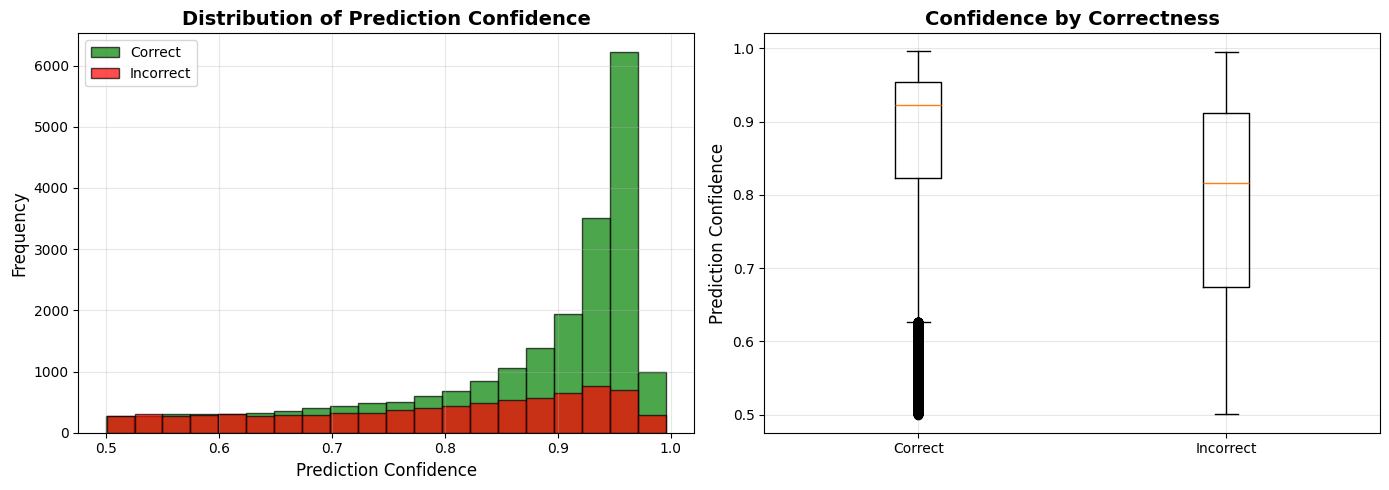

In [9]:
# ============================================================================
# PHASE 7: EVALUATION
# ============================================================================

print("\n" + "="*80)
print("PHASE 7: EVALUATION")
print("="*80)

# Evaluate on validation set
print("\nValidation Set Evaluation:")
val_results = trainer.evaluate()

print("\nValidation Metrics:")
for key, value in sorted(val_results.items()):
    if not key.startswith('eval_runtime'):
        print(f"  {key}: {value:.4f}")

# Evaluate on test set
print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Classification report
print("\nClassification Report:")
print(classification_report(
    labels,
    preds,
    target_names=list(ID2LABEL.values()),
    digits=4
))

# Overall metrics
accuracy = accuracy_score(labels, preds)
f1_macro = f1_score(labels, preds, average='macro')
f1_weighted = f1_score(labels, preds, average='weighted')

print(f"\n📊 Overall Test Set Metrics:")
print(f"  Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  F1 (macro):   {f1_macro:.4f}")
print(f"  F1 (weighted): {f1_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(labels, preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(ID2LABEL.values()),
            yticklabels=list(ID2LABEL.values()),
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Confusion Matrix - {MODEL_NAME}', fontweight='bold', fontsize=14)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Plot 2: Percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
annotations = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

sns.heatmap(cm_percent, annot=annotations, fmt='', cmap='RdYlGn',
            xticklabels=list(ID2LABEL.values()),
            yticklabels=list(ID2LABEL.values()),
            ax=axes[1], vmin=0, vmax=100, cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (%)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n💾 Saved: confusion_matrix.png")

# Confusion matrix breakdown
print("\nConfusion Matrix Breakdown:")
for i, true_label in enumerate(ID2LABEL.values()):
    for j, pred_label in enumerate(ID2LABEL.values()):
        count = cm[i, j]
        pct = cm_percent[i, j]
        print(f"  True {true_label:3s} → Predicted {pred_label:3s}: {count:4d} ({pct:5.1f}%)")

# Prediction confidence analysis
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
confidences = np.max(probs, axis=1)

correct_mask = preds == labels
correct_confidences = confidences[correct_mask]
incorrect_confidences = confidences[~correct_mask]

print(f"\n📈 Prediction Confidence:")
print(f"  Correct predictions:")
print(f"    Mean: {correct_confidences.mean():.3f}")
print(f"    Std:  {correct_confidences.std():.3f}")
print(f"  Incorrect predictions:")
print(f"    Mean: {incorrect_confidences.mean():.3f}")
print(f"    Std:  {incorrect_confidences.std():.3f}")

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(correct_confidences, bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Confidence', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot([correct_confidences, incorrect_confidences],
                labels=['Correct', 'Incorrect'])
axes[1].set_ylabel('Prediction Confidence', fontsize=12)
axes[1].set_title('Confidence by Correctness', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_confidence.png', dpi=300, bbox_inches='tight')
print("💾 Saved: prediction_confidence.png")

# Show misclassified examples
misclassified_indices = np.where(preds != labels)[0]
print(f"\n❌ Misclassified Examples: {len(misclassified_indices)} ({len(misclassified_indices)/len(labels)*100:.1f}%)")

if len(misclassified_indices) > 0:
    print("\nShowing first 3 misclassifications:")
    for i, idx in enumerate(misclassified_indices[:3], 1):
        print(f"\n  Example {i}:")
        print(f"    True label:  {ID2LABEL[labels[idx]]}")
        print(f"    Predicted:   {ID2LABEL[preds[idx]]}")
        print(f"    Confidence:  {confidences[idx]:.2%}")
        print(f"    Text (first 150 chars): {test_df.iloc[idx]['full_text'][:150]}...")
        print(f"    Score breakdown: ", end='')
        for j, label_name in ID2LABEL.items():
            print(f"{label_name}={probs[idx][j]:.3f} ", end='')
        print()



In [10]:
# ============================================================================
# PHASE 8: MODEL SAVING
# ============================================================================

print("\n" + "="*80)
print("PHASE 8: MODEL SAVING")
print("="*80)

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save model and tokenizer
print(f"\nSaving model to: {OUTPUT_DIR}")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

# Save label mappings
with open(f"{OUTPUT_DIR}/label_mappings.json", 'w') as f:
    json.dump({
        'id2label': ID2LABEL,
        'label2id': LABEL2ID,
        'label_map': LABEL_MAP
    }, f, indent=2)

# Save training config
with open(f"{OUTPUT_DIR}/training_config.json", 'w') as f:
    json.dump({
        'model_name': MODEL_NAME,
        'train_config': TRAIN_CONFIG,
        'num_samples': {
            'train': len(train_df),
            'val': len(val_df),
            'test': len(test_df),
            'total': len(df)
        },
        'final_metrics': {
            'accuracy': float(accuracy),
            'f1_macro': float(f1_macro),
            'f1_weighted': float(f1_weighted)
        }
    }, f, indent=2)

# Save test predictions
test_results_df = pd.DataFrame({
    'text': test_df['full_text'].values,
    'true_label': [ID2LABEL[l] for l in labels],
    'predicted_label': [ID2LABEL[p] for p in preds],
    'confidence': confidences,
    'correct': preds == labels
})
test_results_df.to_csv(f"{OUTPUT_DIR}/test_predictions.csv", index=False)

print("✅ Model saved successfully!")
print(f"\nSaved files:")
print(f"  - Model weights and config")
print(f"  - Tokenizer")
print(f"  - label_mappings.json")
print(f"  - training_config.json")
print(f"  - test_predictions.csv")


PHASE 8: MODEL SAVING

Saving model to: ./final_model_roberta-base
✅ Model saved successfully!

Saved files:
  - Model weights and config
  - Tokenizer
  - label_mappings.json
  - training_config.json
  - test_predictions.csv


In [11]:
# ============================================================================
# PHASE 9: PREDICTION FUNCTION
# ============================================================================

print("\n" + "="*80)
print("PHASE 9: CREATING PREDICTION FUNCTION")
print("="*80)

def predict_text(title, text, model=None, tokenizer_obj=None, return_all_scores=False):
    """
    Predict the label for a given text

    Args:
        title: Post title
        text: Post content
        model: Model to use (if None, uses global model)
        tokenizer_obj: Tokenizer to use (if None, uses global tokenizer)
        return_all_scores: If True, return scores for all classes

    Returns:
        prediction: Predicted label
        confidence: Confidence score
        all_scores: (optional) Dict of all class scores
    """
    if model is None:
        model = trainer.model
    if tokenizer_obj is None:
        tokenizer_obj = tokenizer

    # Combine title and text
    full_text = title + " " + text

    # Tokenize
    inputs = tokenizer_obj(
        full_text,
        return_tensors="pt",
        truncation=True,
        max_length=TRAIN_CONFIG['max_length'],
        padding=True
    )

    # Move to device
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class_id = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class_id].item()

    # Get label
    predicted_label = ID2LABEL[predicted_class_id]

    if return_all_scores:
        all_scores = {
            ID2LABEL[i]: probabilities[0][i].item()
            for i in range(len(ID2LABEL))
        }
        return predicted_label, confidence, all_scores

    return predicted_label, confidence

# Test the function
print("\n🧪 Testing prediction function:")

test_cases = [
    {
        "title": "AITA for refusing to share my food?",
        "text": "I bought lunch for myself and my coworker asked if they could have some. I said no because I'm hungry."
    },
    {
        "title": "AITA for helping my elderly neighbor?",
        "text": "My 80-year-old neighbor struggles with groceries, so I offered to help her carry them upstairs every week."
    },
    {
        "title": "AITA for yelling at my roommate?",
        "text": "My roommate keeps leaving dirty dishes in the sink for days. I've asked nicely 10 times. Today I finally yelled."
    }
]

for i, case in enumerate(test_cases, 1):
    pred, conf, scores = predict_text(
        case['title'],
        case['text'],
        return_all_scores=True
    )

    print(f"\n  Case {i}:")
    print(f"    Title: {case['title']}")
    print(f"    Prediction: {pred}")
    print(f"    Confidence: {conf:.2%}")
    print(f"    All scores: {', '.join([f'{k}={v:.2%}' for k, v in scores.items()])}")


PHASE 9: CREATING PREDICTION FUNCTION

🧪 Testing prediction function:

  Case 1:
    Title: AITA for refusing to share my food?
    Prediction: YTA
    Confidence: 73.38%
    All scores: NTA=26.62%, YTA=73.38%

  Case 2:
    Title: AITA for helping my elderly neighbor?
    Prediction: YTA
    Confidence: 56.80%
    All scores: NTA=43.20%, YTA=56.80%

  Case 3:
    Title: AITA for yelling at my roommate?
    Prediction: NTA
    Confidence: 89.69%
    All scores: NTA=89.69%, YTA=10.31%


In [12]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("🎉 PIPELINE COMPLETE!")
print("="*80)

print(f"\n📊 Final Results Summary:")
print(f"  Model: {MODEL_NAME}")
print(f"  Training samples: {len(train_df):,}")
print(f"  Test accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test F1 (macro): {f1_macro:.4f}")
print(f"  Model saved to: {OUTPUT_DIR}")

print(f"\n📁 Generated Files:")
print(f"  - token_length_distribution.png")
print(f"  - confusion_matrix.png")
print(f"  - prediction_confidence.png")
print(f"  - {OUTPUT_DIR}/ (model files)")

print(f"\n💡 Next Steps:")
print(f"  1. Review the confusion matrix to understand errors")
print(f"  2. Check misclassified examples for patterns")
print(f"  3. Load the model for inference: AutoModelForSequenceClassification.from_pretrained('{OUTPUT_DIR}')")
print(f"  4. Deploy the model or continue fine-tuning")

print("\n" + "="*80)
print("Thank you for using this pipeline! 🚀")
print("="*80)


🎉 PIPELINE COMPLETE!

📊 Final Results Summary:
  Model: roberta-base
  Training samples: 147,010
  Test accuracy: 0.7215 (72.15%)
  Test F1 (macro): 0.6572
  Model saved to: ./final_model_roberta-base

📁 Generated Files:
  - token_length_distribution.png
  - confusion_matrix.png
  - prediction_confidence.png
  - ./final_model_roberta-base/ (model files)

💡 Next Steps:
  1. Review the confusion matrix to understand errors
  2. Check misclassified examples for patterns
  3. Load the model for inference: AutoModelForSequenceClassification.from_pretrained('./final_model_roberta-base')
  4. Deploy the model or continue fine-tuning

Thank you for using this pipeline! 🚀
